In [ ]:
!pip install openpyxl

In [1]:
# import modules
import torch    

In [2]:
import numpy as np
import json
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import os
from modules_modified import ISAB, SAB, PMA
import pandas as pd
import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Mappings --------------------------------------------------------
# Map each hold like "A1"…"K18" to an integer 0…(11*18−1)=197
cols = [chr(c) for c in range(ord('A'), ord('K')+1)]
rows = list(range(1, 19))
hold_to_idx = {f"{c}{r}": i for i, (c, r) in enumerate((c, r) for r in rows for c in cols)}


# Map grades "V4"…"V11" 
grade_to_label = {f"V{i}": i - 4 for i in range(4, 12)}  
label_to_grade = {v: k for k, v in grade_to_label.items()}

In [4]:
# Holds difficulty data --------------------------------------------------------
hold_difficulty = {}
with open("hold_difficulty.txt", "r") as f:
    for line in f:
        if ":" not in line:
            continue  # skip malformed line
        hold, rest = line.strip().split(":", 1)
        parts = rest.strip().split(",")
        difficulty = int(parts[0].strip())
        types = [t.strip() for t in parts[1:]]
        hold_difficulty[hold.strip()] = (difficulty, types)
    print("successfully parsed hold difficulty file")

# prepare type vocabulary
unique_types = set()
for _, (_, types) in hold_difficulty.items():
    unique_types.update(types)

type_to_idx = {t: i for i, t in enumerate(sorted(unique_types))}
print(f"successfully prepare type vocabulary")

successfully parsed hold difficulty file
successfully prepare type vocabulary


In [131]:
print(type_to_idx)
print(hold_difficulty)

{'crimp': 0, 'foothold': 1, 'gaston': 2, 'jug': 3, 'pinch': 4, 'pocket': 5, 'sidepull': 6, 'sloper': 7, 'under': 8, 'undercling': 9}
{'A1': (3, ['foothold']), 'A2': (5, ['foothold']), 'A3': (3, ['foothold']), 'A4': (1, ['jug', 'under']), 'A5': (5, ['pinch']), 'A6': (3, ['foothold']), 'A7': (7, ['pinch']), 'A8': (5, ['jug']), 'A9': (4, ['crimp']), 'A10': (7, ['sloper']), 'A11': (4, ['pocket']), 'A12': (3, ['jug']), 'A13': (7, ['pinch']), 'A14': (5, ['pinch']), 'A15': (4, ['pinch']), 'A16': (6, ['pinch']), 'A17': (5, ['crimp']), 'A18': (5, ['jug']), 'B1': (5, ['foothold']), 'B2': (5, ['foothold']), 'B3': (6, ['under']), 'B4': (4, ['jug']), 'B5': (7, ['sloper']), 'B6': (3, ['jug']), 'B7': (7, ['pinch']), 'B8': (8, ['pinch']), 'B9': (8, ['pinch']), 'B10': (9, ['sloper', 'crimp', 'sidepull']), 'B11': (7, ['pinch', 'crimp']), 'B12': (7, ['crimp']), 'B13': (7, ['crimp', 'pinch']), 'B14': (7, ['pinch']), 'B15': (6, ['sloper']), 'B16': (8, ['pinch']), 'B17': (10, ['pinch']), 'B18': (3, ['jug'])

In [ ]:
# Dataset ---------------------------------------------------------
class MoonBoardDataset(Dataset):
    def __init__(self, json_path, hold_to_idx, grade_to_label, hold_difficulty, type_to_idx, max_difficulty=10):
        self.hold_to_idx = hold_to_idx
        self.grade_to_label = grade_to_label
        self.hold_difficulty = hold_difficulty
        self.type_to_idx = type_to_idx
        self.max_difficulty = max_difficulty

        with open(json_path, 'r') as f:
            self.raw = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        item = self.raw[idx]
        holds = item['holds']

        try:
            hold_idxs = [self.hold_to_idx[h] for h in holds]
        except KeyError as e:
            print(f"[ERROR] Invalid hold in item {idx}: {holds}")
            raise e

        # Get difficulty and multi-hot type per hold
        diff_values = []
        type_vectors = []

        for h in holds:
            if h not in self.hold_difficulty:
                raise ValueError(f"[ERROR] Hold {h} not found in hold_difficulty")

            difficulty, types = self.hold_difficulty[h]
            # normalize difficulty value
            diff_values.append(difficulty / self.max_difficulty)

            type_vec = torch.zeros(len(self.type_to_idx), dtype=torch.float)
            for t in types:
                if t in self.type_to_idx:
                    type_vec[self.type_to_idx[t]] = 1.0
                else:
                    raise ValueError(f"[ERROR] Unknown type '{t}' in hold {h}")
            type_vectors.append(type_vec)

        return {
            'indices': torch.tensor(hold_idxs, dtype=torch.long),
            'difficulty': torch.tensor(diff_values, dtype=torch.float),
            'type': torch.stack(type_vectors)  # shape (N, T)
        }, torch.tensor(self.grade_to_label[item['grade']], dtype=torch.long)



In [ ]:
# Classifier Model -----------------------------------------------

# --- set transformer model ---
class SetTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, dim_in=64, dim_hidden=128, num_heads=4, num_inds=16, num_classes=8):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, dim_in)  # hold embedding
        input_dim = dim_in + 1 + len(type_to_idx)  # hold_emb + difficulty + multi-hot vector

        self.encoder = nn.Sequential(
            ISAB(input_dim, dim_hidden, num_heads, num_inds, ln=True),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=True),
        )

        self.decoder = nn.Sequential(
            PMA(dim_hidden, num_heads, 1, ln=True),
            nn.Flatten(start_dim=1),
            nn.Linear(dim_hidden, num_classes)
        )

    def forward(self, inputs):
        hold_idx, difficulty, type_tensor = inputs  # type_tensor: multi-hot (B, N, T)

        x_embed = self.embedding(hold_idx)          # (B, N, dim_in)
        difficulty = difficulty.unsqueeze(-1)       # (B, N, 1)

        x = torch.cat([x_embed, difficulty, type_tensor], dim=-1)  # (B, N, D+1+T)
        x_enc = self.encoder(x)
        return self.decoder(x_enc)


    
# --- deepset model ---
class DeepSetClassifier(nn.Module):
    def __init__(self, vocab_size, dim_in=64, dim_hidden=128, num_classes=8):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, dim_in)
        input_dim = dim_in + 1 + len(type_to_idx)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, num_classes)
        )

    def forward(self, inputs):
        hold_idx, difficulty, type_tensor = inputs  # (B, N), (B, N), (B, N, T)

        x_embed = self.embedding(hold_idx)           # (B, N, dim_in)
        difficulty = difficulty.unsqueeze(-1)        # (B, N, 1)

        x = torch.cat([x_embed, difficulty, type_tensor], dim=-1)  # (B, N, D+1+T)
        x = self.encoder(x)                                      # (B, N, hidden)
        x = x.mean(dim=1)                                        # (B, hidden)
        out = self.decoder(x)                                    # (B, num_classes)
        return out




In [8]:
# # print the model structure -----------------------------------------------
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SetTransformerClassifier().to(device)
# print(model)

In [ ]:
# Training loop ------------------------------------------------

# --- Set Hyperparameters ---
json_path = './cleaned_moonboard2024_grouped.json'  # input path
embed_dim = 64
batch_size = 16
lr = 1e-4
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- set model type ---
# model_type = "deepset"
model_type = "set_transformer"

# --- Collate Function ---
def collate_batch(batch):
    X_indices = [x["indices"] for x, _ in batch]
    X_difficulty = [x["difficulty"] for x, _ in batch]
    X_type = [x["type"] for x, _ in batch]
    y_batch = [y for _, y in batch]

    X_indices = pad_sequence(X_indices, batch_first=True)
    X_difficulty = pad_sequence(X_difficulty, batch_first=True)
    X_type = pad_sequence(X_type, batch_first=True)
    y_tensor = torch.stack(y_batch)

    return (X_indices, X_difficulty, X_type), y_tensor

# --- Evaluation ---
def evaluate(model, dataloader, device):
    model.eval()
    strict_correct, loose_correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = tuple(x.to(device) for x in X)
            y = y.to(device)
            preds = model(X).argmax(dim=1)
            total += y.size(0)
            strict_correct += (preds == y).sum().item()
            loose_correct += ((preds - y).abs() <= 1).sum().item()

    strict_acc = 100.0 * strict_correct / total
    loose_acc = 100.0 * loose_correct / total
    print(f"Strict Accuracy: {strict_correct}/{total} ({strict_acc:.2f}%)")
    print(f"±1 Grade Accuracy: {loose_correct}/{total} ({loose_acc:.2f}%)")

# --- Dataset Loading ---
def load_dataset(json_path, hold_to_idx, grade_to_label, hold_difficulty, type_to_idx):
    return MoonBoardDataset(json_path, hold_to_idx, grade_to_label, hold_difficulty, type_to_idx)


# --- DataLoader Preparation ---
def prepare_dataloaders(dataset, grade_to_label, batch_size):
    targets = [grade_to_label[item['grade']] for item in dataset.raw]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(targets),
        y=targets
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_idx, val_idx = train_test_split(
        list(range(len(dataset))),
        test_size=0.2,
        stratify=targets,
        random_state=42
    )

    train_data = Subset(dataset, train_idx)
    val_data = Subset(dataset, val_idx)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    return train_loader, val_loader, class_weights, train_idx, val_idx

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0 
        for X, y in train_loader:
            X = tuple(x.to(device) for x in X)
            y = y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch:02d} — loss: {total_loss / len(train_loader):.4f}")

    torch.save(model.state_dict(), pth_path)
    print("Training complete. Model saved.")
    evaluate(model, val_loader, device)

# --- Model selection ---
if model_type == "set_transformer":
    vocab_size = len(hold_to_idx)
    num_classes = len(grade_to_label) - 1  # adjust if needed
    ModelClass = SetTransformerClassifier
    pth_path = 'set_transformer_multihot.pth'
    model_kwargs = dict(
        vocab_size=vocab_size,
        dim_in=embed_dim,
        num_classes=num_classes
    )

elif model_type == "deepset":
    vocab_size = len(hold_to_idx)
    num_classes = len(grade_to_label) - 1
    ModelClass = DeepSetClassifier
    pth_path = 'deepset_multihot.pth'
    model_kwargs = dict(
        vocab_size=vocab_size,
        dim_in=embed_dim,
        num_classes=num_classes
    )

else:
    raise ValueError("Unknown model_type")


# --- Main ---
def main():
    dataset = load_dataset(json_path, hold_to_idx, grade_to_label, hold_difficulty, type_to_idx)
    train_loader, val_loader, class_weights, train_idx, val_idx = prepare_dataloaders(dataset, grade_to_label, batch_size)

    model = ModelClass(**model_kwargs).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    return train_loader, val_loader, model, dataset, train_idx, val_idx  

# --- run the program ---
train_loader, val_loader, model, dataset, train_idx, val_idx = main()

Epoch 01 — loss: 1.7267
Epoch 02 — loss: 1.5979
Epoch 03 — loss: 1.5525
Epoch 04 — loss: 1.5195
Epoch 05 — loss: 1.4898
Epoch 06 — loss: 1.4633
Epoch 07 — loss: 1.4412
Epoch 08 — loss: 1.4046
Epoch 09 — loss: 1.3725
Epoch 10 — loss: 1.3502
Epoch 11 — loss: 1.3235
Epoch 12 — loss: 1.2837
Epoch 13 — loss: 1.2602
Epoch 14 — loss: 1.2129
Epoch 15 — loss: 1.1906
Epoch 16 — loss: 1.1492
Epoch 17 — loss: 1.1090
Epoch 18 — loss: 1.0819
Epoch 19 — loss: 1.0423
Epoch 20 — loss: 1.0108
Training complete. Model saved.
Strict Accuracy: 896/2078 (43.12%)
±1 Grade Accuracy: 1659/2078 (79.84%)


In [209]:
# --- For evaluation, export, etc. ---
model = ModelClass(**model_kwargs).to(device)
model.load_state_dict(torch.load(pth_path))
model.eval()

SetTransformerClassifier(
  (embedding): Embedding(198, 64)
  (encoder): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=75, out_features=128, bias=True)
        (fc_v): Linear(in_features=75, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=75, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(


In [210]:
# export to excel ------------------------------------------------
def export_predictions_to_excel(model, dataloader, device, grade_to_label, output_path="predictions.xlsx"):
    results = []

    raw_dataset = dataloader.dataset.dataset  # MoonBoardDataset
    indices = dataloader.dataset.indices      # indices of val data

    label_to_grade = {v: k for k, v in grade_to_label.items()}
    current_index = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = tuple(x.to(device) for x in X)
            y = y.to(device)
            preds = model(X).argmax(dim=1)

            for i in range(y.size(0)):
                real_label = y[i].item()
                pred_label = preds[i].item()
                dataset_index = indices[current_index]
                current_index += 1

                problem_name = raw_dataset.raw[dataset_index]['problem_name']

                results.append({
                    "problem_name": problem_name,
                    "y_true": label_to_grade[real_label],
                    "y_pred": label_to_grade[pred_label]
                })
    
    df = pd.DataFrame(results)
    df.to_excel(output_path, index=False)
    print(f"Predictions exported to: {output_path}")


# Call with corrected grade_to_label
grade_to_label_modified = {f"V{i}": i - 4 for i in range(4, 12)}
export_predictions_to_excel(model, val_loader, device, grade_to_label_modified)

Predictions exported to: predictions.xlsx


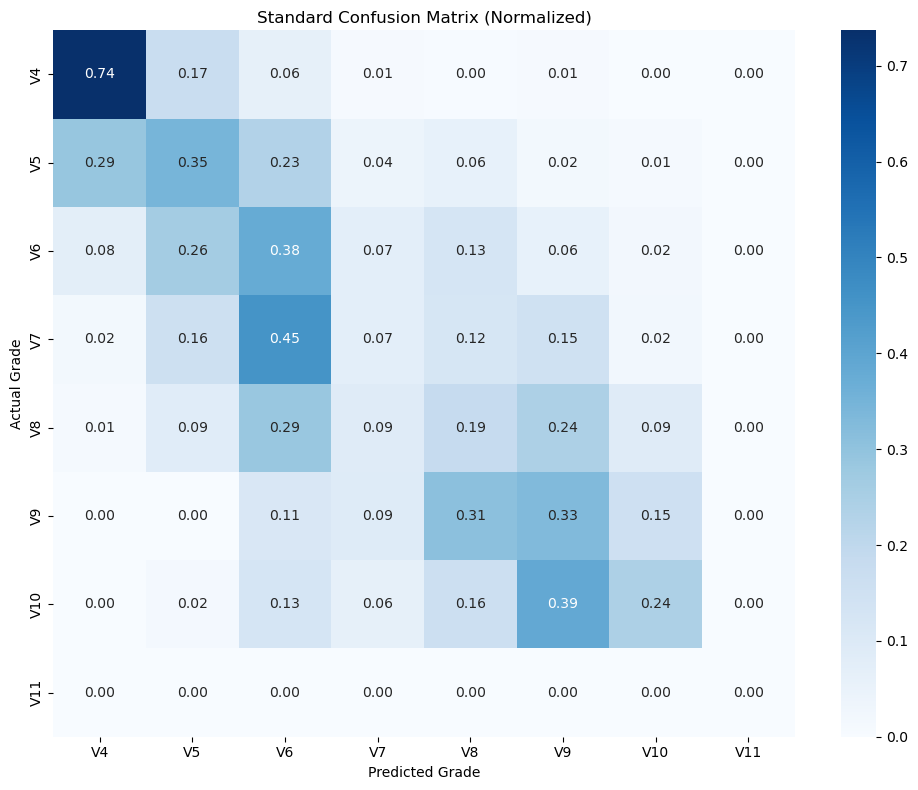


±1 Grade Accuracy by Class:
V4 (592/650): 0.91
V5 (539/621): 0.87
V6 (196/274): 0.72
V7 (107/165): 0.65
V8 (109/209): 0.52
V9 (77/97): 0.79
V10 (39/62): 0.63
V11 (0/0): 0.00

Overall ±1 Grade Accuracy: 1659/2078 = 0.80


In [211]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting ------------------------------------------------
def plot_confusion_matrices_with_tolerance(model, dataloader, device, class_labels):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X = tuple(x.to(device) for x in X)
            y = y.to(device)
            preds = model(X).argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Standard Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)), normalize='true')
    cm_raw = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)), normalize=None)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Standard Confusion Matrix (Normalized)")
    plt.xlabel("Predicted Grade")
    plt.ylabel("Actual Grade")
    plt.tight_layout()
    plt.show()

    print("\n±1 Grade Accuracy by Class:")
    for i in range(len(class_labels)):
        row_total = cm_raw[i].sum()
        near_correct = sum([
            cm_raw[i, j] for j in range(len(class_labels)) if abs(i - j) <= 1
        ])
        accuracy = near_correct / row_total if row_total > 0 else 0
        print(f"{class_labels[i]} ({near_correct}/{row_total}): {accuracy:.2f}")

    overall_correct = sum(
        cm_raw[i, j] for i in range(len(class_labels)) for j in range(len(class_labels)) if abs(i - j) <= 1
    )
    overall_total = cm_raw.sum()
    overall_acc = overall_correct / overall_total
    print(f"\nOverall ±1 Grade Accuracy: {overall_correct}/{overall_total} = {overall_acc:.2f}")

    return y_true, y_pred

class_labels = [f"V{i}" for i in range(4, 12)]  # V4–V11
y_true, y_pred = plot_confusion_matrices_with_tolerance(model, val_loader, device, class_labels)

In [212]:
import numpy as np

# count MSE per true grade  ------------------------------------------------

def mse_per_true_grade(y_true, y_pred, class_labels):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for i, label in enumerate(class_labels):
        mask = (y_true == i)
        if mask.sum() == 0:
            continue
        mse = np.mean((y_pred[mask] - y_true[mask]) ** 2)
        print(f"MSE for true grade {label}: {mse:.3f}")

mse_per_true_grade(y_true, y_pred, class_labels)

MSE for true grade V4: 0.875
MSE for true grade V5: 1.842
MSE for true grade V6: 2.029
MSE for true grade V7: 2.194
MSE for true grade V8: 2.852
MSE for true grade V9: 1.856
MSE for true grade V10: 4.081


In [213]:
def evaluate_problems(
    model, problem_dict, hold_to_idx, hold_difficulty, type_to_idx, device,
    grade_to_label, dataset, train_idx, val_idx
):
    label_to_grade = {v: k for k, v in grade_to_label.items()}
    print("\n=== MoonBoard Problem Evaluation (No XY) ===\n")

    for fallback_name, holds in problem_dict.items():
        try:
            hold_idxs = []
            diff_values = []
            type_vecs = []

            for h in holds:
                if h not in hold_difficulty or h not in hold_to_idx:
                    raise ValueError(f"[ERROR] Hold '{h}' missing from required dictionaries.")

                hold_idxs.append(hold_to_idx[h])
                difficulty, types = hold_difficulty[h]
                diff_values.append(difficulty / 10.0)

                type_vec = torch.zeros(len(type_to_idx), dtype=torch.float)
                for t in types:
                    if t in type_to_idx:
                        type_vec[type_to_idx[t]] = 1.0
                type_vecs.append(type_vec)

            hold_tensor = torch.tensor(hold_idxs, dtype=torch.long).unsqueeze(0).to(device)
            difficulty_tensor = torch.tensor(diff_values, dtype=torch.float).unsqueeze(0).to(device)
            type_tensor = torch.stack(type_vecs).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                logits = model((hold_tensor, difficulty_tensor, type_tensor))
                pred_label = logits.argmax(dim=1).item()
                pred_grade = label_to_grade.get(pred_label, f"Unknown({pred_label})")

        except Exception as e:
            print(f"[{fallback_name}] ❌ Skipping due to error: {e}")
            continue

        # Look for exact match in dataset
        found_idx = None
        split = "Not Found"
        setter_grade = "Unknown"
        problem_name = fallback_name  # default name

        for idx, item in enumerate(dataset.raw):
            if set(item['holds']) == set(holds):
                found_idx = idx
                setter_grade = item.get('grade', 'Unknown')
                problem_name = item.get('problem_name', fallback_name)
                if found_idx in train_idx:
                    split = "Train"
                elif found_idx in val_idx:
                    split = "Validation"
                else:
                    split = "Found (Unknown Split)"
                break

        # Print result
        print(f"🔹 Problem Name   : {problem_name}")
        print(f"   Holds Used     : {holds}")
        print(f"   Setter Grade   : {setter_grade}")
        print(f"   Predicted Grade: {pred_grade}")
        print(f"   Dataset Split  : {split}\n")

named_problems = {
    "Physical V9 Benchmark": ["I18", "J12", "F13", "D10", "E6", "J2"],
    "Triangulation V7": ["A18", "J13", "D16", "E9", "E9", "I4"],
    "warmup crimps": ["I18", "I7", "I9", "I15", "G11", "J14", "J12", "I15", "J14", "H4", "K6"],
    "Ronani V5": ["F18", "I15", "I10", "K9", "K6", "G14", "D16", "E9", "K6", "I15", "E4", "H5"],
    "Don't Fart Alan": ["K18", "J15", "F14", "F13", "D10", "E6", "I7", "I5", "F1"],
    "FINALE MAXI 2025 POCKET 2 V9": ["G3", "F3", "F4", "A6", "A11", "B17", "C9", "D17", "H18"],
    "Khai's V7": ["D18", "A15", "A12", "C9", "E7", "H8", "I6", "E1"],
    "Yums In My Tums V5": ["F18", "G12", "E1", "D13", "I9", "F8", "I2", "F16", "E4", "E6"],
}

group1 = {
    "simma mot strommen": ["A18", "C12", "A9", "B14", "B16", "D1", "F5", "F5"],
    "MAXIMUS!": ["K18", "E3", "K14", "I13", "K7", "I2", "H16", "K11", "G7", "H4"],
    "interstate": ["K18", "H17", "J11", "I9", "G13", "H15", "I5", "I6"],
    "krakatoa pusher": ["H18", "H11", "J8", "F7", "K15", "F4", "J3"],
    "doublement": ["A18", "E16", "F8", "B14", "G8", "E12", "F4", "F3", "F3"],
    "animal instinct": ["F18", "J11", "F9", "H15", "E13", "J11", "I6", "F4"],
    "blue bin day": ["B18", "C18", "A8", "C12", "B15", "A5", "C3"]
}


evaluate_problems(
    model=model,
    problem_dict=named_problems,
    hold_to_idx=hold_to_idx,
    hold_difficulty=hold_difficulty,
    type_to_idx=type_to_idx,
    device=device,
    grade_to_label=grade_to_label,
    dataset=dataset,
    train_idx=train_idx,
    val_idx=val_idx
)




=== MoonBoard Problem Evaluation (No XY) ===

🔹 Problem Name   : PHYSICAL Q
   Holds Used     : ['I18', 'J12', 'F13', 'D10', 'E6', 'J2']
   Setter Grade   : V9
   Predicted Grade: V6
   Dataset Split  : Train

🔹 Problem Name   : TRIANGULATION Q
   Holds Used     : ['A18', 'J13', 'D16', 'E9', 'E9', 'I4']
   Setter Grade   : V7
   Predicted Grade: V5
   Dataset Split  : Train

🔹 Problem Name   : WARMUP CRIMPS Q
   Holds Used     : ['I18', 'I7', 'I9', 'I15', 'G11', 'J14', 'J12', 'I15', 'J14', 'H4', 'K6']
   Setter Grade   : V4
   Predicted Grade: V6
   Dataset Split  : Train

🔹 Problem Name   : RONANI QD
   Holds Used     : ['F18', 'I15', 'I10', 'K9', 'K6', 'G14', 'D16', 'E9', 'K6', 'I15', 'E4', 'H5']
   Setter Grade   : V5
   Predicted Grade: V5
   Dataset Split  : Train

🔹 Problem Name   : Don't Fart Alan
   Holds Used     : ['K18', 'J15', 'F14', 'F13', 'D10', 'E6', 'I7', 'I5', 'F1']
   Setter Grade   : Unknown
   Predicted Grade: V5
   Dataset Split  : Not Found

🔹 Problem Name   : FI

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def visualize_attention_for_problem(model, holds, hold_to_idx, hold_difficulty, type_to_idx, device):
    model.eval()

    hold_idxs = []
    diff_values = []
    type_vecs = []

    for h in holds:
        hold_idxs.append(hold_to_idx[h])
        difficulty, types = hold_difficulty[h]
        diff_values.append(difficulty / 10.0)

        # Multi-hot encoding
        type_vec = torch.zeros(len(type_to_idx), dtype=torch.float)
        for t in types:
            if t in type_to_idx:
                type_vec[type_to_idx[t]] = 1.0
        type_vecs.append(type_vec)

    hold_tensor = torch.tensor(hold_idxs, dtype=torch.long).unsqueeze(0).to(device)
    diff_tensor = torch.tensor(diff_values, dtype=torch.float).unsqueeze(0).to(device)
    type_tensor = torch.stack(type_vecs).unsqueeze(0).to(device)  # (1, N, T)

    with torch.no_grad():
        _ = model((hold_tensor, diff_tensor, type_tensor))

    attn_isab1 = model.encoder[0].mab0.attn_weights.cpu().numpy()
    attn_isab2 = model.encoder[1].mab0.attn_weights.cpu().numpy()

    num_heads = attn_isab1.shape[0]
    fig, axes = plt.subplots(2, num_heads, figsize=(4 * num_heads, 8))
    if num_heads == 1:
        axes = axes.reshape(2, 1)

    for h in range(num_heads):
        sns.heatmap(attn_isab1[h], ax=axes[0, h], cmap="viridis", xticklabels=holds)
        axes[0, h].set_title(f"ISAB1 – Head {h}")
        axes[0, h].set_xlabel("Key (Hold)")
        axes[0, h].set_ylabel("Seed")

        sns.heatmap(attn_isab2[h], ax=axes[1, h], cmap="viridis", xticklabels=holds)
        axes[1, h].set_title(f"ISAB2 – Head {h}")
        axes[1, h].set_xlabel("Key (Hold)")
        axes[1, h].set_ylabel("Seed")

    plt.tight_layout()
    plt.show()

In [215]:
def get_avg_attention_per_hold(model, holds, hold_to_idx, hold_difficulty, type_to_idx, device):
    model.eval()

    hold_idxs = []
    diff_values = []
    type_vecs = []

    for h in holds:
        hold_idxs.append(hold_to_idx[h])
        difficulty, types = hold_difficulty[h]
        diff_values.append(difficulty / 10.0)

        type_vec = torch.zeros(len(type_to_idx), dtype=torch.float)
        for t in types:
            if t in type_to_idx:
                type_vec[type_to_idx[t]] = 1.0
        type_vecs.append(type_vec)

    hold_tensor = torch.tensor(hold_idxs, dtype=torch.long).unsqueeze(0).to(device)
    diff_tensor = torch.tensor(diff_values, dtype=torch.float).unsqueeze(0).to(device)
    type_tensor = torch.stack(type_vecs).unsqueeze(0).to(device)

    with torch.no_grad():
        _ = model((hold_tensor, diff_tensor, type_tensor))

    attn_weights = model.encoder[0].mab0.attn_weights  # (heads, seeds, holds)
    avg_attn = attn_weights.mean(dim=(0, 1)).cpu().numpy()  # (num_holds,)

    return list(zip(holds, avg_attn))


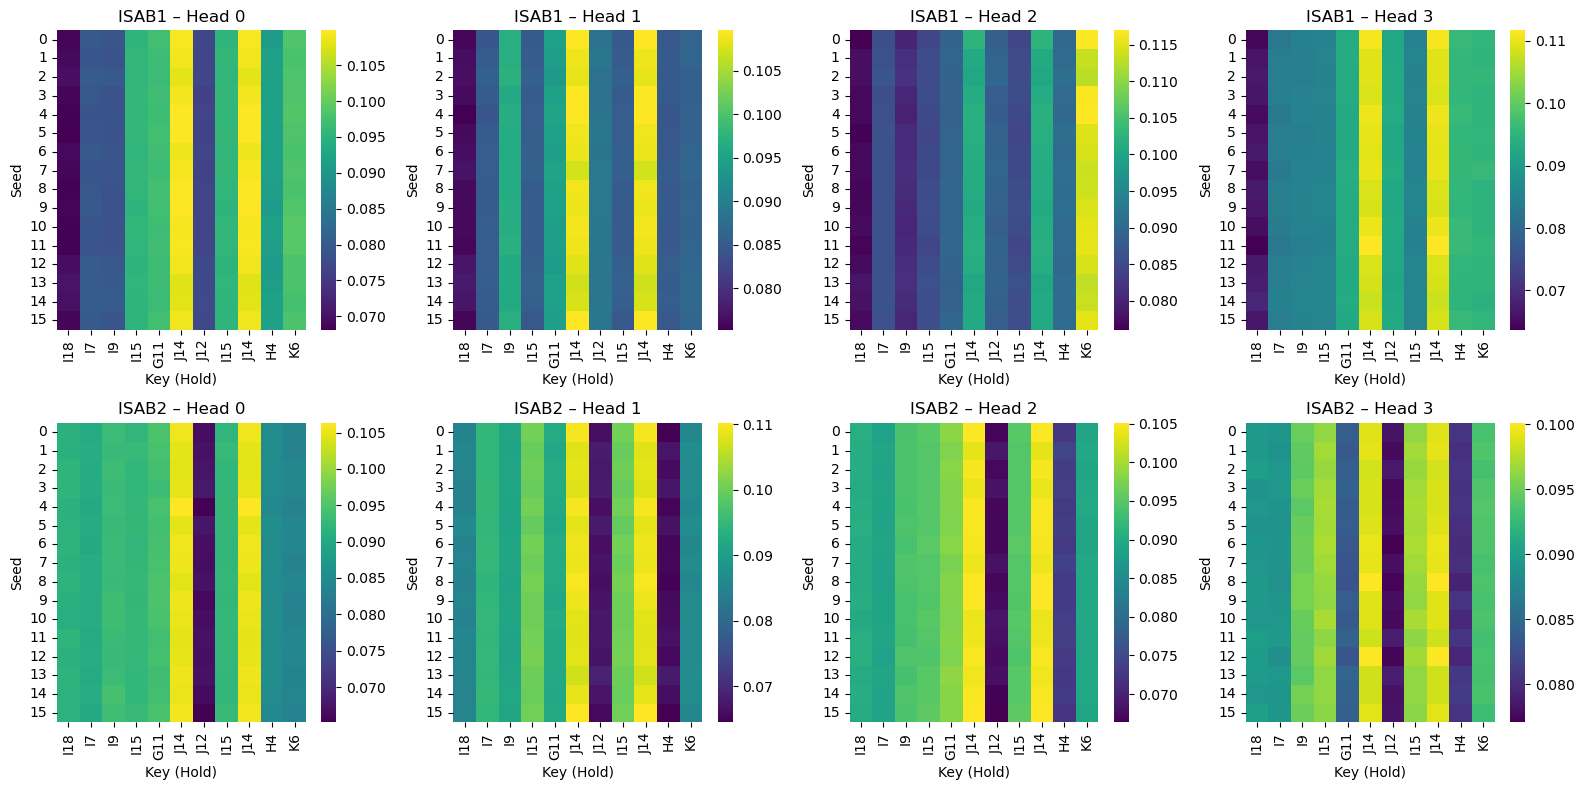

Average Attention Per Hold (sorted):
J14: 0.1071 (difficulty: 6)
J14: 0.1071 (difficulty: 6)
K6: 0.0985 (difficulty: 6)
G11: 0.0934 (difficulty: 7)
H4: 0.0905 (difficulty: 4)
I15: 0.0878 (difficulty: 8)
I15: 0.0878 (difficulty: 8)
J12: 0.0866 (difficulty: 8)
I9: 0.0853 (difficulty: 7)
I7: 0.0837 (difficulty: 6)
I18: 0.0721 (difficulty: 3)


In [216]:
# usage for attention map visualization
holds = named_problems["warmup crimps"]

visualize_attention_for_problem(model, holds, hold_to_idx, hold_difficulty, type_to_idx, device)
attention_scores = get_avg_attention_per_hold(model, holds, hold_to_idx, hold_difficulty, type_to_idx, device)

attention_scores_sorted = sorted(attention_scores, key=lambda x: x[1], reverse=True)

print("Average Attention Per Hold (sorted):")
for h, score in attention_scores_sorted:
    difficulty = hold_difficulty[h][0] if h in hold_difficulty else "N/A"
    print(f"{h}: {score:.4f} (difficulty: {difficulty})")
